# Text Classification Procedure and Results

The following notebook details the machine learning procedure and results for training a classification model on the BCStats WES Comment data. The purpose of this notebook is to illustrate the details of the code in a digestable format.

This analysis notebook best accompanies the [MDS Final Report]() which introduces the problem and more formally describes the methodology and results. To learn how to implement the data on future WES comments see the [WES Classification USAGE]() notebook.

In [1]:
# Change working directory to be project root
import os
os.chdir("..")
os.getcwd()

'/Users/aaronquinton/Documents/UBC-MDS/Capstone/BCstats/DSCI_591_capstone-BCStats'

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import time
import src

# Custom functions for preprocessing, data preparation, and evaluation
from src.data.preprocessing_text import (
    clean_text, clean_numbers, replace_typical_misspell, remove_stopwords,
    preprocess_for_embed, preprocess_for_bow
)

from src.features.word_vectors import (
    build_vocab, check_coverage, get_average_embeddings
)

from src.models.eval import theme_results, investigate_results, subtheme_results

# Functions for preprocessing, data preparation, and evaluation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# Training Word embeddings and pre-trained embeddings
import gensim
from gensim.models import Word2Vec, KeyedVectors

# Keras Deep learning functions for LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPooling1D, Conv1D, GlobalAveragePooling1D
from keras.layers import GRU, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

# Classification alogrithms
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


## <span style = "color:Darkblue"> Read in Data and Embeddings </span>

In [39]:
# Input Filepaths
# Data Files
fname_rawdata2018 = "data/interim/train_2018-qualitative-data.csv"
fname_quant = "data/processed/tidy_quant_questions.csv"
fname_legend = "references/data-dictionaries/survey_mc_legend.csv"

# Pre-trained Embeddings
fname_fasttext_crawl = "./references/pretrained_embeddings.nosync/fasttext/" \
                       "crawl-300d-2M.vec"
fname_fasttext_wiki = "./references/pretrained_embeddings.nosync/fasttext/" \
                      "wiki-news-300d-1M.vec"
fname_w2v_googlenews = "./references/pretrained_embeddings.nosync/" \
                       "GoogleNews-vectors-negative300.bin"
fname_glove_twitter = "./references/pretrained_embeddings.nosync/glove/" \
                      "glove.twitter.27B.200d.w2v.txt"
fname_glove_wiki = "./references/pretrained_embeddings.nosync/glove/" \
                      "glove.6B.300d.w2v.txt"
fname_glove_crawl = "./references/pretrained_embeddings.nosync/glove/" \
                      "glove.840B.300d.w2v.txt"

In [4]:
# Read in raw data
df = pd.read_csv(fname_rawdata2018)

In [40]:
t_start = time.time()

# Read in pre-trained embeddings
w2v_google_news = KeyedVectors.load_word2vec_format(fname_w2v_googlenews,
                                                    binary=True)
fasttext_crawl = KeyedVectors.load_word2vec_format(fname_fasttext_crawl,
                                                   unicode_errors='ignore')
fasttext_wiki = KeyedVectors.load_word2vec_format(fname_fasttext_wiki,
                                                  unicode_errors='ignore')
glove_twitter = KeyedVectors.load_word2vec_format(fname_glove_twitter,
                                                  unicode_errors='ignore')
glove_wiki = KeyedVectors.load_word2vec_format(fname_glove_wiki,
                                               unicode_errors='ignore')
glove_crawl = KeyedVectors.load_word2vec_format(fname_glove_crawl,
                                                unicode_errors='ignore')

t_end = time.time()
print("Elapsed time to load embeddings: %.1f s" % (t_end - t_start))

Elapsed time to load embeddings: 3042.0 s


## <span style = "color:Darkblue"> Preprocessing and Data Preperation</span>

### Preparing Comment data

In [12]:
df_userid = df[['_telkey', '2018 Comment']]
df_userid = df_userid.rename(columns = {'_telkey':'USERID'})

df = df[['2018 Comment']].join(df.loc[:,'CPD_Improve_new_employee_orientation':'Unrelated'])
df = df.rename(columns = {'2018 Comment' : 'comment'})

Y = np.array(df.loc[:,'CPD_Improve_new_employee_orientation':'Unrelated'])

subthemes = df.loc[:,'CPD_Improve_new_employee_orientation':'Unrelated'].columns.tolist()

# Split the data
df_X_train, df_X_valid, Y_train, Y_valid = train_test_split(
        df.comment, Y, test_size=0.25, random_state=2019)

In [13]:
print(df_X_train.shape)
print(Y_train.shape)

(9958,)
(9958, 62)


### Prepare Quantitative Data

In [20]:
df_quant = pd.read_csv(fname_quant).query("survey_year == 2018")
df_legend = pd.read_csv(fname_legend)

In [21]:
df_quant_train = df_userid.loc[df_X_train.index] \
                          .merge(df_quant, how='left', on='USERID')

df_quant_valid = df_userid.loc[df_X_valid.index] \
                          .merge(df_quant, how='left', on='USERID')

In [22]:
X_train_quant = np.array(df_quant_train.iloc[:,3:20])
X_valid_quant = np.array(df_quant_valid.iloc[:,3:20])

In [23]:
# Fill missing values with the mean response for that column
for i in range(X_train_quant.shape[1]):
    mean_replace = np.nanmean(X_train_quant, axis = 0)[i]
    X_train_quant[:,i][np.isnan(X_train_quant[:,i])] = mean_replace
    X_valid_quant[:,i][np.isnan(X_valid_quant[:,i])] = mean_replace


In [24]:
print(X_train_quant.shape)
print(X_valid_quant.shape)

(9958, 17)
(3320, 17)


### Train Word Vectors

In [41]:
comments = preprocess_for_embed(df.comment, 'w2v_base_model')

w2v_base_model = Word2Vec(comments, 
                     size=300, 
                     window=5, 
                     min_count=1,
                     sg=1, 
                     negative=4)        

[autoreload of src.models.eval failed: Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/aaronquinton/Documents/UBC-MDS/Capstone/BCstats/DSCI_591_cap

In [51]:
# Dictionary of pretrained embeddings
embeddings = {#'w2v_base_model': w2v_base_model,
              'w2v_google_news': w2v_google_news, 
              'fasttext_crawl': fasttext_crawl,
              #'fasttext_wiki': fasttext_wiki,
              #'glove_twitter': glove_twitter,
              'glove_wiki': glove_wiki,
              'glove_crawl': glove_crawl}

### Word Embedding Vocab Coverage

In [243]:
# Check coverage of vocab words in embedding
oov = {}
vocab_coverage = []
text_coverage = []

for embedding in embeddings.keys():
    
    comments = preprocess_for_embed(df.comment, embedding)
    vocab = build_vocab(comments)
        
    a, b, oov[embedding] = check_coverage(vocab, embeddings[embedding])
    
    vocab_coverage.append(a)
    text_coverage.append(b)

pd.DataFrame({'embedding': list(embeddings.keys()),
              'vocab_coverage': vocab_coverage, 
              'text_coverage': text_coverage})

100%|██████████| 17500/17500 [00:06<00:00, 2735.08it/s]


,embedding,vocab_coverage,text_coverage
0,w2v_base_model,1.000000,1.000000
1,w2v_google_news,0.939870,0.996661
2,fasttext_crawl,0.953943,0.997412
3,fasttext_wiki,0.938514,0.996345
4,glove_twitter,0.887954,0.990666
5,glove_wiki,0.913479,0.994892
6,glove_crawl,0.953543,0.997421


In [244]:
# Take a look at the out of vocab words for each embedding
for i in oov.keys():
    print(i)
    print(oov[i][:5])

w2v_base_model
[]
w2v_google_news
[('CYMH', 54), ('FLNRORD', 35), ('GCPE', 33), ('CSNR', 32), ('BCWS', 23)]
fasttext_crawl
[('CYMH', 54), ('BCTS', 37), ('FLNRORD', 35), ('GCPE', 33), ('CSNR', 32)]
fasttext_wiki
[('MCFD', 128), ('CYMH', 54), ('BCTS', 37), ('FLNRORD', 35), ('GCPE', 33)]
glove_twitter
[('2', 402), ('1', 302), ('3', 236), ('4', 171), ('5', 151)]
glove_wiki
[('####', 181), ('mcfd', 131), ('cymh', 54), ('#####', 49), ('bcts', 37)]
glove_crawl
[('CYMH', 54), ('FLNRORD', 35), ('GCPE', 33), ('CSNR', 32), ('STIIP', 20)]


## <span style = "color:Darkblue"> Feature Engineering </span>

### Bag of Words


In [25]:
# Use Count Vectorizer to build bag of word arrays to train on
vectorizer = CountVectorizer(stop_words= 'english',
                             ngram_range=(1,5), 
                             min_df=2)   

X_train_bow = vectorizer.fit_transform(preprocess_for_bow(df_X_train))
X_valid_bow = vectorizer.transform(preprocess_for_bow(df_X_valid))

In [26]:
print(X_train_bow.shape)
print(X_valid_bow.shape)

(9958, 31422)
(3320, 31422)


### Get Average Word Vectors per Comment

In [247]:
X_train_avg_wv = {}
X_valid_avg_wv = {}

for embedding in embeddings.keys():
    
    # Adjust features based on twitter embeddings 
    if embedding == 'glove_twitter':
        n_features = 200
    else:
        n_features = 300
    
    # Preprocess comment data
    comments_train = preprocess_for_embed(df_X_train, embedding)
    comments_valid = preprocess_for_embed(df_X_valid, embedding)
    
    # Get average embeddings for each comment
    # train
    X_train_avg_wv[embedding] = np.array(
        [get_average_embeddings(comment, embeddings[embedding], n_features)
         for comment in comments_train])
    
    # valid
    X_valid_avg_wv[embedding] = np.array(
        [get_average_embeddings(comment, embeddings[embedding], n_features)
         for comment in comments_valid])

In [248]:
print(X_valid_avg_wv['w2v_base_model'].shape)
print(X_valid_avg_wv['glove_twitter'].shape)

(3320, 300)
(3320, 200)


## <span style = "color:Darkblue"> Classification Models </span>
### Baseline Classifier - BOW | Linear SVC 

#### Final BOW | Linear SVC Model

In [27]:
t_start = time.time()
print("Training Bag of words Model with Linear SVC")

model_bow = BinaryRelevance(
    classifier = LinearSVC(C = 0.5, tol = 0.2)
)

model_bow.fit(X_train_bow, Y_train)
t_end_train = time.time()

Y_pred_bow = model_bow.predict(X_valid_bow).toarray()

# Calculate and print elapsed time
t_end = time.time()
print("Elapsed Training time: %.1f s" % (t_end_train - t_start),
      "\nElapsed Predict time: %.1f s" % (t_end - t_end_train))

Training Bag of words Model with Linear SVC
Elapsed Training time: 364.0 s 
Elapsed Predict time: 64.3 s


In [31]:
results_bow = pd.DataFrame({'Model': 'BOW | LinearSVC',
                            'train_time': [364],
                            'predict_time': [64.3],
                            'overall_accuracy': [metrics.accuracy_score(Y_valid, 
                                                                       Y_pred_bow)]})

In [32]:
results_bow

,Model,train_time,predict_time,overall_accuracy
0,BOW | LinearSVC,364,64.3,0.30512


In [50]:
subtheme_results(Y_valid, Y_pred_bow)

Overall Accuracy: 0.3051 
Hamming Loss: 0.0205 
Hamming Loss (pred. zeros): 0.0263


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Label,Y_count,Pred_count,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD_Improve_new_employee_orientation,49,35,0.008434,0.00633,0.991566,0.800000,0.571429
1,CPD_Improve_performance_management,24,4,0.007831,-0.00060,0.992169,0.250000,0.041667
2,CPD_Improve_training,274,227,0.055723,0.02681,0.944277,0.696035,0.576642
3,CPD_Provide_opportunities_advancement,119,87,0.033133,0.00271,0.966867,0.551724,0.403361
4,CPD_other,6,1,0.002108,-0.00030,0.997892,0.000000,0.000000
5,CB_Ensure_salary_parity_across_gov,30,5,0.009940,-0.00090,0.990060,0.200000,0.033333
6,CB_Ensure_salary_parity_with_other_orgs,137,114,0.028012,0.01325,0.971988,0.692982,0.576642
7,CB_Improve_benefits,114,97,0.016566,0.01777,0.983434,0.804124,0.684211
8,CB_Increase_salary,330,329,0.056928,0.04247,0.943072,0.714286,0.712121
9,CB_Review_job_classifications,73,44,0.020181,0.00181,0.979819,0.568182,0.342466


In [839]:
print("Shape of Y_pred:",Y_pred_bow.shape)
print("Zeros predicted:",Y_pred_bow[Y_pred_bow.sum(axis = 1) == 0,:].shape)

Shape of Y_pred: (3320, 12)
Zeros predicted: (466, 12)


In [64]:
test = "This_is_a_test.h5"

In [66]:
test.replace('.h5', '_glove_crawl.h5')

'This_is_a_test_glove_crawl.h5'

In [67]:
with open()

'This_is_a_test.h5'

### LSTM Model

In [52]:
# Build Embedding Matrices and prepare data for deep 
# learning Models
max_words = 12000
maxlen = 700

# dictionaries for each embedding
embedding_matrix = {}
tokenizer = {}
X_train_lstm = {}
X_valid_lstm = {}

for embedding in embeddings.keys():

    # Preprocess text data based on embedding
    X_train = np.array(preprocess_for_embed(df_X_train,
                                            embedding,
                                            split = False))
    
    X_valid = np.array(preprocess_for_embed(df_X_valid,
                                            embedding,
                                            split = False))
    
    # Tokenize and pad numbers for LSTM Model
    tokenizer[embedding] = Tokenizer(num_words=max_words)
    tokenizer[embedding].fit_on_texts(X_train)
    
    tokenized_train = tokenizer[embedding].texts_to_sequences(X_train)
    tokenized_test = tokenizer[embedding].texts_to_sequences(X_valid)

    X_train_lstm[embedding] = pad_sequences(tokenized_train, maxlen=maxlen)
    X_valid_lstm[embedding] = pad_sequences(tokenized_test, maxlen=maxlen)
    
    
    # Build Embedding Matrices
    if embedding == 'glove_twitter':
        embed_size = 200
    else:
        embed_size = 300

    word_index = tokenizer[embedding].word_index
    
    num_words = min(max_words, len(word_index) + 1)
    embedding_matrix[embedding] = np.zeros((num_words, embed_size),
                                           dtype='float32')

    for word, i in word_index.items():

        if i >= max_words:
            continue

        try:
            embedding_vector = embeddings[embedding][word]

            if embedding_vector is not None:
                embedding_matrix[embedding][i] = embedding_vector
        except:
            continue

In [53]:
# Build LSTM Model and train and validate
Y_pred_lstm = {}
model_lstm = {}
train_time = []
predict_time = []
accuarcies = []

for embedding in ['glove_crawl']:
    t_start = time.time()
    print("Training LSTM on the ", embedding)
    
    if embedding == 'glove_twitter':
        embed_size = 200
    else:
        embed_size = 300
    
    # Deep Learning Architecture
    inp = Input(shape=(maxlen, ))
    
    x = Embedding(max_words, embed_size, 
                  weights=[embedding_matrix[embedding]], 
                  trainable=False)(inp)

    x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1,
                          recurrent_dropout=0.1))(x)

    x = Conv1D(64, kernel_size=3, padding="valid", 
               kernel_initializer="glorot_uniform")(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)

    x = concatenate([avg_pool, max_pool])

    preds = Dense(62, activation="sigmoid")(x)

    model = Model(inp, preds)

    model.compile(loss='binary_crossentropy',
                  optimizer= 'adam',
                  metrics=['accuracy'])

    # Train and Predict Model
    batch_size = 128
    epochs = 8
    model.fit(X_train_lstm[embedding],
              Y_train,
              batch_size=batch_size,
              epochs=epochs, 
              validation_data = (X_valid_lstm[embedding],
                                 Y_valid))
    t_end_train = time.time()
    
    Y_pred_lstm[embedding] = model.predict(X_valid_lstm[embedding])
    model_lstm[embedding] = model

    # Calculate and report results
    t_end = time.time()
    train_time.append(t_end_train - t_start)
    predict_time.append(t_end - t_end_train)
    
    accuarcies.append(metrics.accuracy_score(Y_valid,
                                             np.round(Y_pred_lstm[embedding])))

Training LSTM on the  glove_crawl
Train on 9958 samples, validate on 3320 samples
Epoch 1/8
9958/9958 [==============================] - 379s 38ms/step - loss: 0.1818 - acc: 0.9448 - val_loss: 0.1115 - val_acc: 0.9737
Epoch 2/8
9958/9958 [==============================] - 387s 39ms/step - loss: 0.1059 - acc: 0.9736 - val_loss: 0.0961 - val_acc: 0.9747
Epoch 3/8
9958/9958 [==============================] - 375s 38ms/step - loss: 0.0917 - acc: 0.9749 - val_loss: 0.0852 - val_acc: 0.9759
Epoch 4/8
9958/9958 [==============================] - 370s 37ms/step - loss: 0.0822 - acc: 0.9763 - val_loss: 0.0782 - val_acc: 0.9774
Epoch 5/8
9958/9958 [==============================] - 373s 37ms/step - loss: 0.0759 - acc: 0.9774 - val_loss: 0.0739 - val_acc: 0.9780
Epoch 6/8
9958/9958 [==============================] - 381s 38ms/step - loss: 0.0704 - acc: 0.9785 - val_loss: 0.0708 - val_acc: 0.9786
Epoch 7/8
9958/9958 [==============================] - 383s 38ms/step - loss: 0.0660 - acc: 0.9795 - v

In [55]:
results_lstm = pd.DataFrame({'embedding': 'glove_crawl',
                             'train_time': train_time,
                             'predict_time': predict_time,
                             'overall_accuracy': accuarcies})

results_lstm

,embedding,train_time,predict_time,overall_accuracy
0,glove_crawl,3019.810872,43.905211,0.262349


In [57]:
subtheme_results(Y_valid, np.round(Y_pred_lstm['glove_crawl']))

Overall Accuracy: 0.2623 
Hamming Loss: 0.0206 
Hamming Loss (pred. zeros): 0.0263


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Label,Y_count,Pred_count,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD_Improve_new_employee_orientation,49,0,0.014759,0.00000,0.985241,0.000000,0.000000
1,CPD_Improve_performance_management,24,0,0.007229,-0.00000,0.992771,0.000000,0.000000
2,CPD_Improve_training,274,242,0.053614,0.02892,0.946386,0.698347,0.616788
3,CPD_Provide_opportunities_advancement,119,50,0.032831,0.00301,0.967169,0.600000,0.252101
4,CPD_other,6,0,0.001807,-0.00000,0.998193,0.000000,0.000000
5,CB_Ensure_salary_parity_across_gov,30,0,0.009036,-0.00000,0.990964,0.000000,0.000000
6,CB_Ensure_salary_parity_with_other_orgs,137,67,0.030120,0.01114,0.969880,0.776119,0.379562
7,CB_Improve_benefits,114,87,0.021988,0.01235,0.978012,0.735632,0.561404
8,CB_Increase_salary,330,423,0.062349,0.03705,0.937651,0.645390,0.827273
9,CB_Review_job_classifications,73,5,0.020482,0.00151,0.979518,1.000000,0.068493


In [69]:
test = model_lstm['glove_crawl']

In [72]:
test.save('/models/my_model.h5')

OSError: Unable to create file (unable to open file: name = '/models/my_model.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

### Model Summary

#### BOW

In [56]:
results_bow

,Model,train_time,predict_time,overall_accuracy
0,BOW | LinearSVC,364,64.3,0.30512


#### Average Word Vectors

In [1084]:
results_avg_wv

,embedding,train_time,predict_time,overall_accuracy
0,w2v_base_model,6.191823,0.065399,0.360843
1,w2v_google_news,4.602850,0.222380,0.406325
2,fasttext_crawl,5.089044,0.190777,0.421687
3,fasttext_wiki,4.718872,0.276683,0.398795
4,glove_twitter,7.091348,0.339133,0.354217
5,glove_wiki,9.596981,0.359630,0.406024
6,glove_crawl,8.432222,0.280792,0.409337


#### LSTM

In [1082]:
results_lstm

,embedding,train_time,predict_time,overall_accuracy
0,w2v_base_model,3879.478145,50.835208,0.463253
1,w2v_google_news,3545.128112,50.347810,0.502108
2,fasttext_crawl,3841.778025,57.008378,0.507530
3,fasttext_wiki,3767.888280,53.533103,0.490060
4,glove_twitter,2847.951580,40.823633,0.488855
5,glove_wiki,3199.954429,46.572131,0.498795
6,glove_crawl,3316.253327,51.455602,0.507530


## Ensemble Model Predictions

In [1181]:
Y_pred_stack = (Y_pred_lstm['fasttext_crawl'] +
                Y_pred_lstm['glove_crawl'] +
                Y_pred_lstm['glove_wiki'] +
                Y_pred_lstm['w2v_google_news'])/4

In [1182]:
theme_results(Y_valid, np.round(Y_pred_stack))

Overall Accuracy: 0.5386 
Hamming Loss: 0.0588 
Hamming Loss (pred. zeros): 0.1191


,Label,Y_proportion,Pred_proportion,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD,0.127410,0.113855,0.060542,0.066867,0.939458,0.793651,0.709220
1,CB,0.184639,0.178012,0.034940,0.149699,0.965060,0.920474,0.887439
2,EWC,0.084337,0.044880,0.060542,0.023795,0.939458,0.765101,0.407143
3,Exec,0.103012,0.098795,0.069880,0.033133,0.930120,0.667683,0.640351
4,FWE,0.062048,0.053916,0.020181,0.041867,0.979819,0.888268,0.771845
5,SP,0.096386,0.087048,0.059940,0.036446,0.940060,0.709343,0.640625
6,RE,0.085542,0.065964,0.062952,0.022590,0.937048,0.671233,0.517606
7,Sup,0.127711,0.105422,0.083735,0.043976,0.916265,0.708571,0.584906
8,SW,0.165964,0.145181,0.090060,0.075904,0.909940,0.761411,0.666062
9,TEPE,0.228614,0.223494,0.050301,0.178313,0.949699,0.898922,0.878788


### Increase the Precision! 

In [1187]:
accuracy = []
prob_adj = []
non_zero_percent = []

for i in np.arange(-0.49,0.5,0.01):
    
    prob_adj.append(min((0.5 + i),1))
    predictions = np.round(Y_pred_stack - i)
    
    size = predictions.shape[0]
    zero_size = (predictions[predictions.sum(axis = 1) == 0,:].shape[0])
    
    non_zero_pred = predictions[predictions.sum(axis = 1) != 0,:]
    non_zero_valid = Y_valid[predictions.sum(axis = 1) != 0,:]
    
    accuracy.append(metrics.accuracy_score(non_zero_valid, non_zero_pred))
    non_zero_percent.append(round(1 - zero_size/size, 4))

results_tradeoff = pd.DataFrame({'prob_adj': prob_adj,
                                 'accuracy':accuracy,
                                 'non_zero_percent':non_zero_percent})


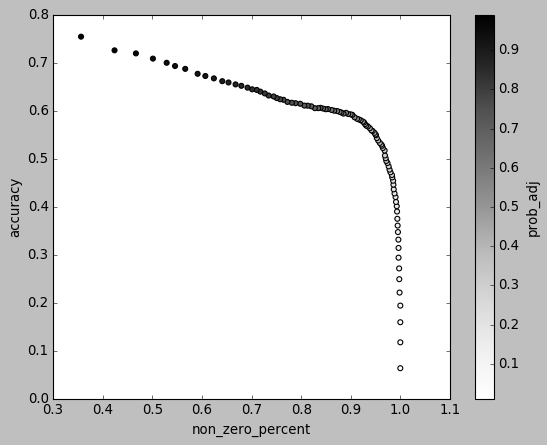

In [1188]:
p = results_tradeoff.plot.scatter(x = 'non_zero_percent',
                              y = 'accuracy',
                              c = 'prob_adj')

plt.show()

In [62]:
predictions = np.round(Y_pred_lstm['glove_crawl'] - 0.45)

a = subtheme_results(Y_valid, predictions)
size = predictions.shape[0]
zero_size = (predictions[predictions.sum(axis = 1) == 0,:].shape[0])
print("Total comments:", size, 
      "\nTotal Predictions:", size - zero_size, 
      "\nPercent Pred non-zero:", round(1 - zero_size/size, 4))
a

Overall Accuracy: 0.0934 
Hamming Loss: 0.024 
Hamming Loss (pred. zeros): 0.0263


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Total comments: 3320 
Total Predictions: 520 
Percent Pred non-zero: 0.1566


,Label,Y_count,Pred_count,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD_Improve_new_employee_orientation,49,0,0.014759,0.00000,0.985241,0.000000,0.000000
1,CPD_Improve_performance_management,24,0,0.007229,-0.00000,0.992771,0.000000,0.000000
2,CPD_Improve_training,274,24,0.075904,0.00663,0.924096,0.958333,0.083942
3,CPD_Provide_opportunities_advancement,119,0,0.035843,-0.00000,0.964157,0.000000,0.000000
4,CPD_other,6,0,0.001807,-0.00000,0.998193,0.000000,0.000000
5,CB_Ensure_salary_parity_across_gov,30,0,0.009036,-0.00000,0.990964,0.000000,0.000000
6,CB_Ensure_salary_parity_with_other_orgs,137,0,0.041265,-0.00000,0.958735,0.000000,0.000000
7,CB_Improve_benefits,114,13,0.030422,0.00392,0.969578,1.000000,0.114035
8,CB_Increase_salary,330,82,0.078313,0.02108,0.921687,0.926829,0.230303
9,CB_Review_job_classifications,73,0,0.021988,0.00000,0.978012,0.000000,0.000000


In [63]:
non_zero_pred = predictions[predictions.sum(axis = 1) != 0,:]
non_zero_valid = Y_valid[predictions.sum(axis = 1) != 0,:]

subtheme_results(non_zero_valid, non_zero_pred)

Overall Accuracy: 0.5962 
Hamming Loss: 0.0098 
Hamming Loss (pred. zeros): 0.0245


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Label,Y_count,Pred_count,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD_Improve_new_employee_orientation,1,0,0.001923,0.00000,0.998077,0.000000,0.000000
1,CPD_Improve_performance_management,1,0,0.001923,0.00000,0.998077,0.000000,0.000000
2,CPD_Improve_training,28,24,0.011538,0.04231,0.988462,0.958333,0.821429
3,CPD_Provide_opportunities_advancement,2,0,0.003846,0.00000,0.996154,0.000000,0.000000
4,CPD_other,0,0,0.000000,0.00000,1.000000,0.000000,0.000000
5,CB_Ensure_salary_parity_across_gov,1,0,0.001923,0.00000,0.998077,0.000000,0.000000
6,CB_Ensure_salary_parity_with_other_orgs,8,0,0.015385,0.00000,0.984615,0.000000,0.000000
7,CB_Improve_benefits,25,13,0.023077,0.02500,0.976923,1.000000,0.520000
8,CB_Increase_salary,90,82,0.038462,0.13462,0.961538,0.926829,0.844444
9,CB_Review_job_classifications,2,0,0.003846,0.00000,0.996154,0.000000,0.000000
